http://nbviewer.ipython.org/github/justmarkham/gadsdc1/blob/master/logistic_assignment/kevin_logistic_sklearn.ipynb

## Dataset
* dataset : [affairs dataset](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html)
* 불륜 경험이 있는 유부녀들에게 물어본 조사 결과임

## 변수들의 설명
9개 변수에 6366개의 관찰결과가 포함되어 있음
* rate_marriage : 그녀의 결혼 만족도(1=very poor 5 = very good)
* age : 여성의 나이
* yrs_married : 결혼한 년수
* children : 아이의 수
* religious : 여성의 종교적 신념도 (1 = not religious, 4 = strongly religious)
* educ : 교육수전 (9 = 초등교육, 12 = 고등학교, 14 = 대학을 다님, 16 = 대학 졸업, 17 = 대학원을 다님, 20 = 고급 학위(석/박사))
* occupation : 여성의 직업 (1=학생, 2=농업/준기술/기술이 없음, 3=화이트 칼라(white collar), 4=선생/간호사/작가/기술자/숙련공, 5=관리자급/기업가, 6= 고학력 전문직)
* occupation_husb : 남편의 직업(위와 동일)
* affairs : 불륜한 기간(time spent in extra-marital affairs)

## 문제 설명(Problem Statement)
* 새로운 이진 변수를 생성함으로써, 분류 문제로 다루려고한다. 그리고 각 여성에 대해서 분류를 예상할 것이다. 정사를 했는지 안했느지에 대해서)

# import modules

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Data Pre-processing

In [6]:
dta = sm.datasets.fair.load_pandas().data
dta['affair'] = (dta.affairs>0).astype(int)

# Data Exploration(데이터 조사(탐사))

In [7]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


In [9]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


* 나이, 결혼한 년수와 아이의 수가 결혼만족도와 관련있어보임

# Visualization
* 교육과 결혼만족도에 대해서 히스그램을 그려보자

In [11]:
# show plots in the notebook
%matplotlib inline

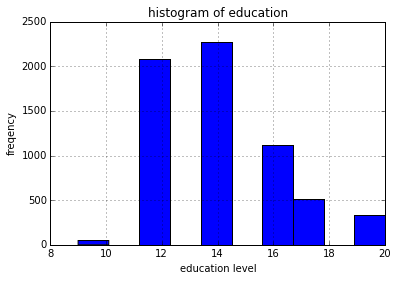

In [12]:
# histogram of education
dta.educ.hist()
plt.title('histogram of education')
plt.xlabel('education level')
plt.ylabel('freqency')

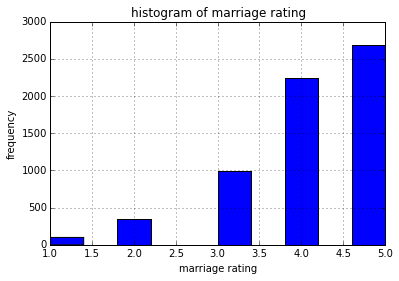

In [14]:
# histogram of marriage rationg
dta.rate_marriage.hist()
plt.title('histogram of marriage rating')
plt.xlabel('marriage rating')
plt.ylabel('frequency')

* 분륜을 한 그룹과 아닌 그룹들에 대한 결혼 만족도의 분포를 살펴보자

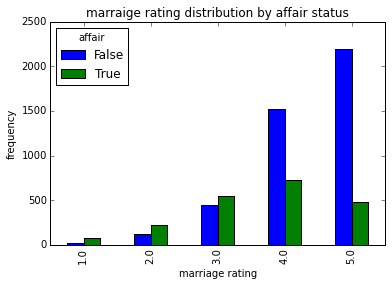

In [16]:
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('marraige rating distribution by affair status')
plt.xlabel('marriage rating')
plt.ylabel('frequency')

* 스택 바플롯을 이용해서, 결혼년수에따른 분륜 경험 여성의 비율을 살펴보자

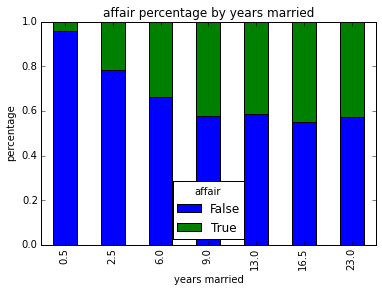

In [19]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('affair percentage by years married')
plt.xlabel('years married')
plt.ylabel('percentage')

# prepare data for logistic regression

데이터를 준비를 위해서, 직업과 남편직업을 위해서 더미 변수로서 칼럼을 추가 할것이다. 왜냐하면 나는 그들을 카테고리성 변수로 다루려고 하기 때문이다.
`dmatrices` 함수는 형식 언어로를 이용해서 그렇게 할수 있다.

In [20]:

y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                           religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type='dataframe')
print X.columns

Index([u'Intercept', u'C(occupation)[T.2.0]', u'C(occupation)[T.3.0]',
       u'C(occupation)[T.4.0]', u'C(occupation)[T.5.0]',
       u'C(occupation)[T.6.0]', u'C(occupation_husb)[T.2.0]',
       u'C(occupation_husb)[T.3.0]', u'C(occupation_husb)[T.4.0]',
       u'C(occupation_husb)[T.5.0]', u'C(occupation_husb)[T.6.0]',
       u'rate_marriage', u'age', u'yrs_married', u'children', u'religious',
       u'educ'],
      dtype='object')


In [21]:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_hub)[T.2.0]':'occ_husb_2',
                        'C(occupation_hub)[T.3.0]':'occ_husb_3',
                        'C(occupation_hub)[T.4.0]':'occ_husb_4',
                        'C(occupation_hub)[T.5.0]':'occ_husb_5',
                        'C(occupation_hub)[T.6.0]':'occ_husb_6',
                       })

In [22]:
y = np.ravel(y)

In [23]:
y

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

In [25]:
X.head()

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,C(occupation_husb)[T.2.0],C(occupation_husb)[T.3.0],C(occupation_husb)[T.4.0],C(occupation_husb)[T.5.0],C(occupation_husb)[T.6.0],rate_marriage,age,yrs_married,children,religious,educ
0,1,1,0,0,0,0,0,0,0,1,0,3,32,9.0,3,3,17
1,1,0,1,0,0,0,0,0,1,0,0,3,27,13.0,3,1,14
2,1,0,1,0,0,0,0,0,0,1,0,4,22,2.5,0,1,16
3,1,0,0,0,1,0,0,0,0,1,0,4,37,16.5,4,3,16
4,1,0,1,0,0,0,0,0,1,0,0,5,27,9.0,1,1,14


# Logistic Regression


In [26]:
model = LogisticRegression()
model = model.fit(X,y)
model.score(X,y)

0.72588752748978946

In [27]:
y.mean()

0.32249450204209867

* 32% 정도의 여자만 분륜을 함..68%정도는 하지 않았다라고함.

In [29]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[1.48988359987]
1,occ_2,[0.188045665478]
2,occ_3,[0.498926113333]
3,occ_4,[0.250646979622]
4,occ_5,[0.838983090673]
5,occ_6,[0.833921375451]
6,C(occupation_husb)[T.2.0],[0.190546667908]
7,C(occupation_husb)[T.3.0],[0.297744484205]
8,C(occupation_husb)[T.4.0],[0.161319259282]
9,C(occupation_husb)[T.5.0],[0.187682907876]


결혼 만족도, 종교정도의 증가가 '불륜' 를 갖게되는 정도를 낮추어 준다. 와이프의 직업과 남편의 직업에 대해서는 최하의 '우도'를 보여준다. 

# 유효셋을 이용한 모델 평가
(model evaluation using a validation set)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [32]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[ 1.  0.  0. ...,  0.  0.  0.]


In [33]:
# getenrate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[ 0.35146341  0.64853659]
 [ 0.90955084  0.09044916]
 [ 0.72567333  0.27432667]
 ..., 
 [ 0.55727384  0.44272616]
 [ 0.81207044  0.18792956]
 [ 0.74734603  0.25265397]]


* 두번째 컬럼이 0.5이상이면, 불륜 일 것이라고(1) 에상하게 된다.

In [34]:
# print generative evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:,1])

0.729842931937
0.745950606951


* 73% 정도의 정확도라서, 위에서 경험했던 부분과 갖다.

In [35]:
print metrics.confusion_matrix(y_test,predicted)
print metrics.classification_report(y_test, predicted)

[[1169  134]
 [ 382  225]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



# 교차검증을 통한 모델 평가(Model Evaluation using cross-validatiaon)
10-fold 교차검증을 이용한다.정확도가 좀더 엄격하게 하기 위해서,

In [37]:
scores = cross_val_score(LogisticRegression(), X,y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.72100313  0.70219436  0.73824451  0.70597484  0.70597484  0.72955975
  0.7327044   0.70440252  0.75157233  0.75      ]
0.724163068551


# 불륜일 확율을 예상하기(Predicting the probability of an affair)
* 재미를 위해서, 예상을 해보자. 25세, 교사ㅏ이고, 대학을 졸업했으며, 결혼 3년차이다. 1명의 자녀가 있고, 그녀는 종교심이 강하다. 그여늬 결혼은 공정하며, 그녀의 남편은 농부이다.

In [39]:
woman = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4,
                              16])
model.predict_proba(woman)

array([[ 0.77472299,  0.22527701]])

* 그녀가 불륜을 저지를 확률은 23%이다.